In [97]:
# Cell 2 – imports & paths

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from nilearn import image, masking
from nilearn.glm.first_level import glover_hrf

# --- Paths ---
PROJECT_ROOT = Path(".")
DATA_ROOT    = PROJECT_ROOT / "data"
DERIV_ROOT   = PROJECT_ROOT / "derivatives" / "music"

# Choose subject and run
sub_id = "sub-005"    # change as needed

# Find BOLD file (handles subfolders and .nii/.nii.gz)
pattern = f"**/{sub_id}_task-Test_run-02_bold.nii*"
bold_candidates = sorted(DATA_ROOT.glob(pattern))
if not bold_candidates:
    raise FileNotFoundError(f"No BOLD file found matching pattern: {pattern}")

bold_path = bold_candidates[0]

# Mask and design paths (from earlier notebooks)
mask_path   = DERIV_ROOT / f"{sub_id}_run-02_mask.nii.gz"
design_path = DERIV_ROOT / f"{sub_id}_run-02_design.csv"

print("BOLD   :", bold_path,   "exists:", bold_path.exists())
print("Mask   :", mask_path,   "exists:", mask_path.exists())
print("Design :", design_path, "exists:", design_path.exists())

BOLD   : data\music\sub-005_task-Test_run-02_bold.nii exists: True
Mask   : derivatives\music\sub-005_run-02_mask.nii.gz exists: True
Design : derivatives\music\sub-005_run-02_design.csv exists: False


In [98]:
# Cell 3 – Load BOLD 4D image, mask, and (if present) design

# Load BOLD 4D image
img = image.load_img(bold_path)
data = img.get_fdata()
shape = img.shape
zooms = img.header.get_zooms()
tr = zooms[3]

print("BOLD shape (x, y, z, t):", shape)
print("TR:", tr)

# Load mask
mask_img = image.load_img(mask_path)
mask_data = mask_img.get_fdata().astype(bool)

print("Mask shape:", mask_data.shape)
print("Masked voxels:", mask_data.sum())

# --- Load design matrix if it exists; otherwise we will build it in the next cell ---
n_scans = shape[-1]                     # number of time points
time_axis = np.arange(n_scans) * tr     # handy for design index

if design_path.exists():
    print("\nDesign file already exists, loading it:")
    design = pd.read_csv(design_path, index_col=0)
    print("Design columns:", list(design.columns))
    print("Design shape  :", design.shape)

    # consistency check
    assert design.shape[0] == n_scans, "Design rows must match number of volumes!"
else:
    print(f"\nDesign matrix NOT found at {design_path}.")
    print("We will BUILD and SAVE it in the NEXT CELL.")
    design = None  # placeholder so we know it's not built yet


BOLD shape (x, y, z, t): (96, 96, 68, 410)
TR: 1.5
Mask shape: (96, 96, 68)
Masked voxels: 145197

Design matrix NOT found at derivatives\music\sub-005_run-02_design.csv.
We will BUILD and SAVE it in the NEXT CELL.


In [99]:
# Cell 4 – Build simple music design matrix and save to CSV (if not already built)

if design is not None:
    print("Design already loaded for", sub_id, "- nothing to build.")
else:
    print(f"Building design matrix for {sub_id} and saving to CSV...")

    # 1) Basic timing info
    n_scans = shape[-1]
    frame_times = np.arange(n_scans) * tr

    # 2) Music boxcar: assume music is on for the whole run
    stim_music = np.ones(n_scans)

    # 3) HRF (Glover) and convolve
    from nilearn.glm.first_level import glover_hrf

    time_length = 32
    hrf_times = np.arange(0, time_length, tr)
    hrf = glover_hrf(tr, oversampling=1, time_length=time_length)

    music_hrf = np.convolve(stim_music, hrf)[:n_scans]

    # 4) Simple design matrix
    design = pd.DataFrame(
        {
            "const": np.ones(n_scans),
            "linear_drift": np.linspace(-1, 1, n_scans),
            "music_boxcar": stim_music,
            "music_hrf": music_hrf,
        },
        index=frame_times,
    )

    print("Design columns:", list(design.columns))
    print("Design shape  :", design.shape)

    # 5) Save it
    design.to_csv(design_path)
    print("Saved design to:", design_path)

Building design matrix for sub-005 and saving to CSV...
Design columns: ['const', 'linear_drift', 'music_boxcar', 'music_hrf']
Design shape  : (410, 4)
Saved design to: derivatives\music\sub-005_run-02_design.csv


Number of brain voxels: 145197
Chosen voxel (x, y, z): 48 29 19
Voxel time series shape: (410,)


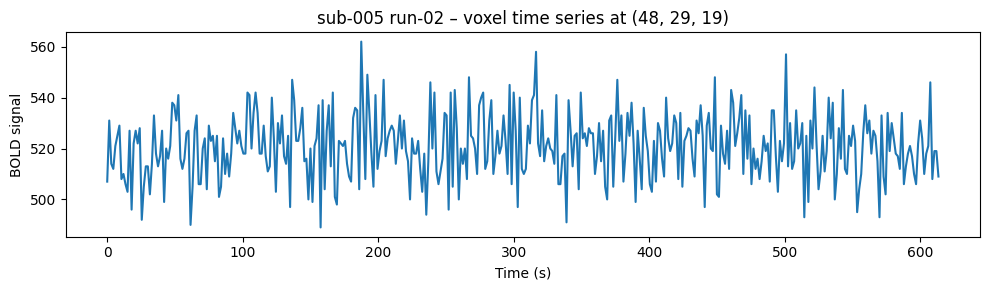

In [100]:
# Cell 4 – Pick a voxel inside mask and inspect its time series

# Get all brain voxel coordinates from the mask
coords = np.argwhere(mask_data)  # each row is [x, y, z]
print("Number of brain voxels:", coords.shape[0])

# Pick roughly the "central" voxel in the list
x0, y0, z0 = coords[len(coords) // 2]
print("Chosen voxel (x, y, z):", x0, y0, z0)

# Extract its time series
voxel_ts = data[x0, y0, z0, :]   # shape (n_scans,)
print("Voxel time series shape:", voxel_ts.shape)

# Plot it
plt.figure(figsize=(10, 3))
plt.plot(time_axis, voxel_ts)
plt.xlabel("Time (s)")
plt.ylabel("BOLD signal")
plt.title(f"{sub_id} run-02 – voxel time series at ({x0}, {y0}, {z0})")
plt.tight_layout()
plt.show()


In [101]:
# Cell 5 – Construct X and y for the GLM

# Ensure columns exist (from your Phase 3 design)
assert "music_hrf" in design.columns and "const" in design.columns

# X: design matrix (T x P), here P = 2: [music_hrf, const]
X = design[["music_hrf", "const"]].values    # shape (T, 2)

# y: voxel time series (T,)
y = voxel_ts

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (410, 2)
y shape: (410,)


In [102]:
# Cell 6 – Solve for β (ordinary least squares)

# Compute β_hat = (X^T X)^(-1) X^T y
XtX = X.T @ X                   # shape (2, 2)
XtX_inv = np.linalg.pinv(XtX)   # pseudo-inverse for stability
Xty = X.T @ y                   # shape (2,)

beta_hat = XtX_inv @ Xty        # shape (2,)
beta_scene, beta_intercept = beta_hat

print("β_hat (scene_hrf, const):", beta_hat)
print("β_scene:", beta_scene)
print("β_intercept:", beta_intercept)


β_hat (scene_hrf, const): [  1.03339844 519.913593  ]
β_scene: 1.0333984395435825
β_intercept: 519.9135929959778


In [103]:
# Cell 7 – Residuals, variance, SE, t-stat for scene regressor

# 1. Predicted signal
y_hat = X @ beta_hat    # shape (T,)

# 2. Residuals
residuals = y - y_hat

# 3. Residual sum of squares
SSE = np.sum(residuals ** 2)

# 4. Degrees of freedom
T, P = X.shape
df = T - P

# 5. Noise variance estimate
sigma2_hat = SSE / df

# 6. Variance-covariance of β_hat
cov_beta = sigma2_hat * XtX_inv   # (2, 2)

# 7. Standard error for scene regressor (index 0)
se_beta_scene = np.sqrt(cov_beta[0, 0])

# 8. t-statistic for H0: β_scene = 0
t_scene = beta_scene / se_beta_scene

print("SSE:", SSE)
print("df :", df)
print("sigma^2_hat:", sigma2_hat)
print("Var(β):\n", cov_beta)
print("SE(β_scene):", se_beta_scene)
print("t_scene:", t_scene)


SSE: 66315.19393992655
df : 408
sigma^2_hat: 162.5372400488396
Var(β):
 [[ 38.437243   -38.32234781]
 [-38.32234781  38.60422836]]
SE(β_scene): 6.1997776575838595
t_scene: 0.1666831452059383


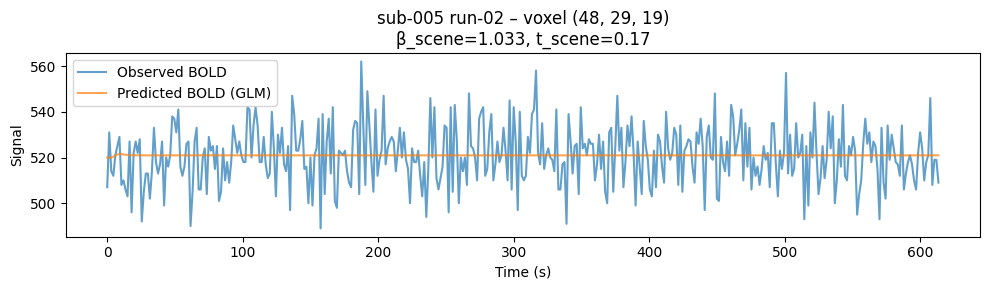

In [104]:
# Cell 8 – Plot observed vs predicted BOLD for that voxel

plt.figure(figsize=(10, 3))
plt.plot(time_axis, y,      label="Observed BOLD",   alpha=0.7)
plt.plot(time_axis, y_hat,  label="Predicted BOLD (GLM)", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title(
    f"{sub_id} run-02 – voxel ({x0}, {y0}, {z0})\n"
    f"β_scene={beta_scene:.3f}, t_scene={t_scene:.2f}"
)
plt.legend()
plt.tight_layout()
plt.show()
